In [1]:
import torch

print(torch.__version__)

2.0.1+cu118


#### 主要内容
* 一维和二维卷积操作；
* CNN架构的组成构件；
* 使用Pytorch实现深度CNN网络;
* 用于提升泛化性能的数据增强技术；
* 实现用于笑脸识别的CNN分类器；

如下图所示，CNN根据输入图像计算特征图(feature maps)， 其中每个元素来自输入图像中的局部像素块：

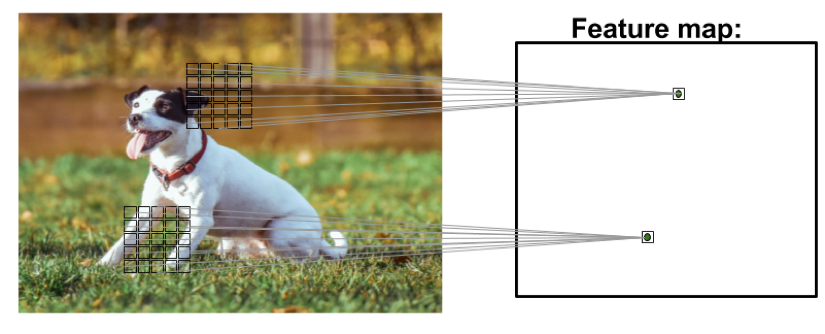

In [2]:
from IPython.display import Image

Image(filename='../Python-MachineLearning/Attached_images/Chapter14/figures/14_01.png', 
      width=450)

其中，这个局部像素块被称为局部感受野(local receptive field). CNN在图像任务上非常出色，得益于如下两个方面：
* **稀疏连接(Sparse connectivity)**：特征图中的元素仅连接到一小块像素；
* **权重共享(Parameter sharing)**：对输入图像的不同块使用相同的权重；

卷积神经网络(Convolutional Neural Networks, CNN)是一种深度学习模型，它在图像和视频识别、分类以及分割任务重非常有效。

对于**稀疏连接**：在传统的全连接网络中，每个神经元都与前一层的所有神经元相连。这种连接方式参数数量非常多，计算复杂度很高。 CNN网络通过使用卷积层来实现稀疏连接。在卷积层中，每个神经元仅与输入数据的一个局部区域相连。这意味着每个卷积核(卷积核就是卷积层中的权重矩阵)只要覆盖输入数据的一个局部区域，而不是整个输入数据。所以这种局部连接方式减少了参数的数量，因为每个卷积核的参数数量远小于全连接层的参数数量，从而降低了计算量和存储需求.

对于**权重共享**：在卷积层中，同一个卷积核对应的权重在整个输入数据上是共享的。也就是说，同一个卷积核在不同的输入区域重复使用。`权重共享的优点是允许模型学习到局部特征的不变性，即相同的特征可以在图像的不同位置被检测到`。

通常，CNN由多个卷积层和子采样层(subsampling layers)组成，最后是一个或多个全连接层。而且，`子采样层通常又被称为池化层(Pooling layers)`,其不具有任何的可学习参数。卷积操作示意如下图：

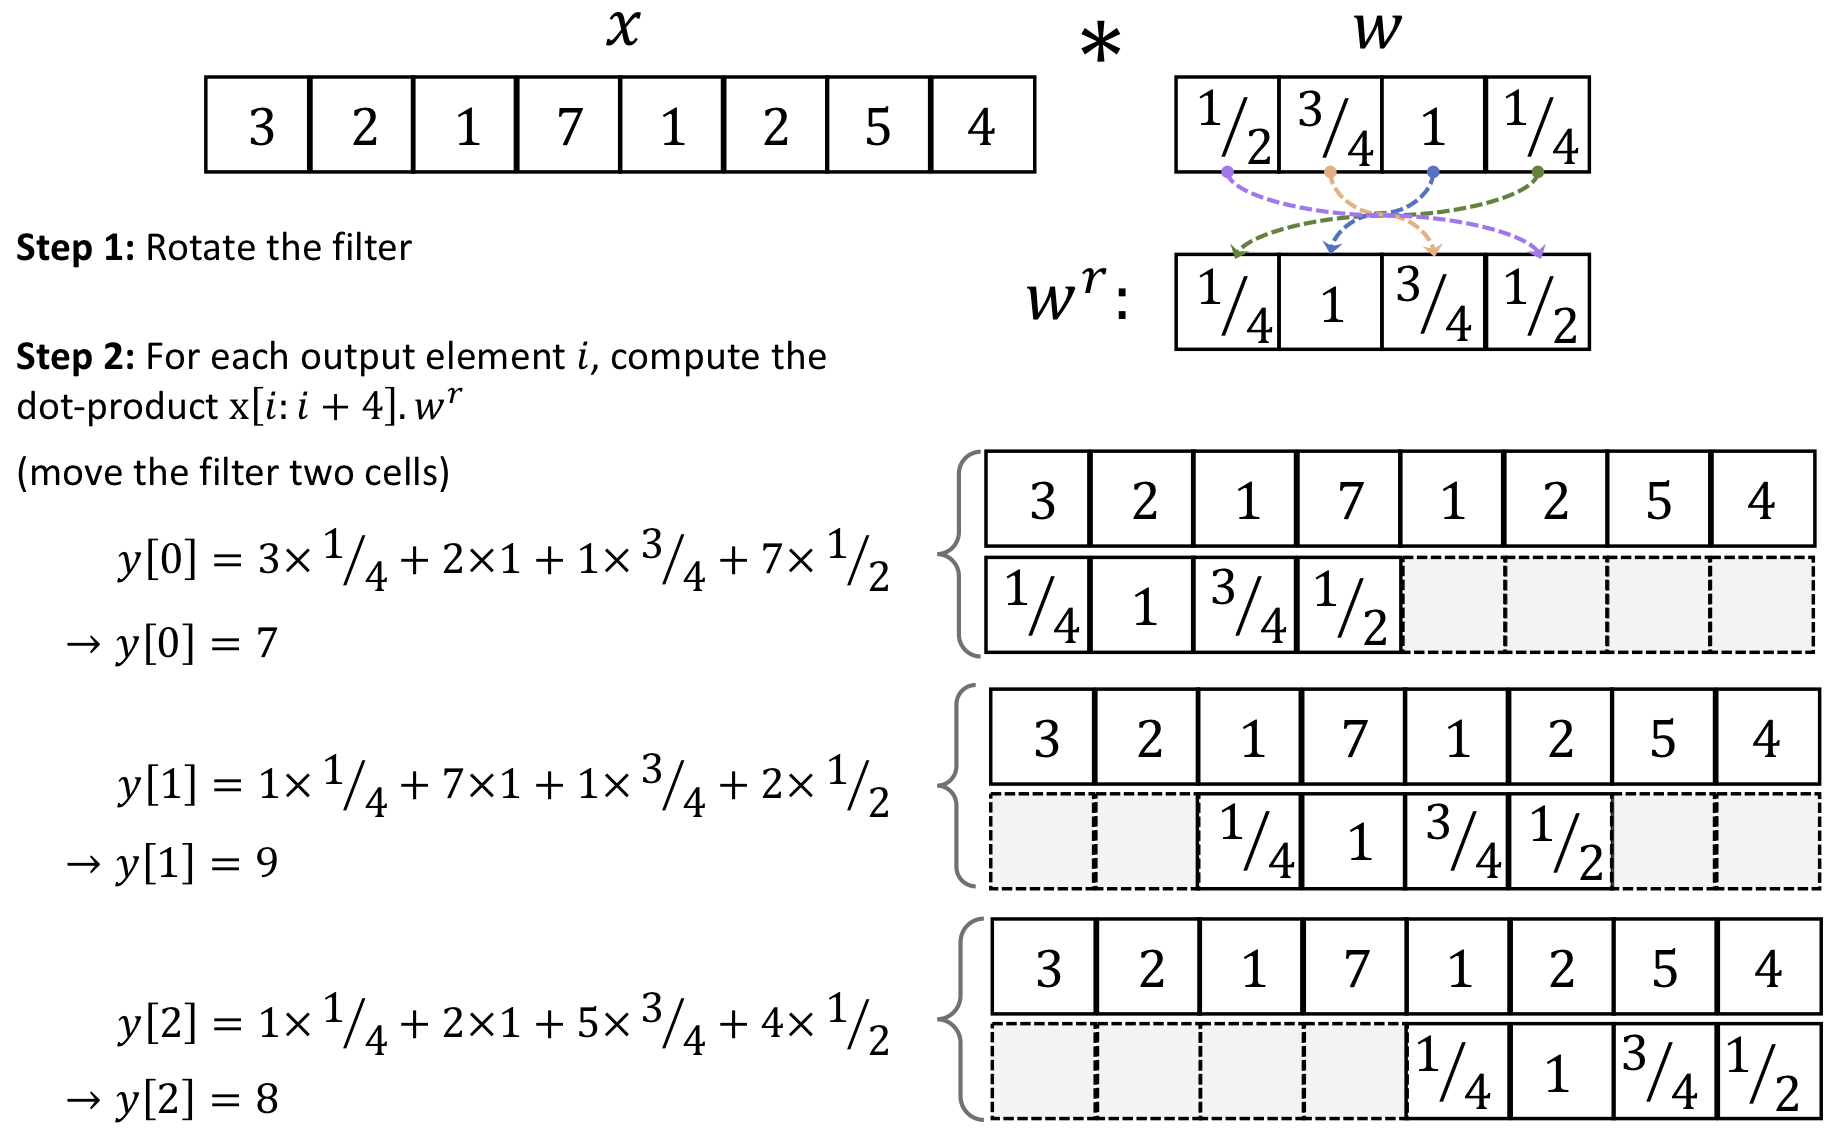

In [3]:
Image(filename='../Python-MachineLearning/Attached_images/Chapter14/figures/14_03.png', 
      width=450)

#### 利用Padding来控制输出特征图的大小

关于Padding的作用：

在神经网络中，特别是在卷积神经网络（CNN）中，padding（填充）有几个重要的原因：

1. **保持特征图的尺寸**：通过在输入数据的边缘添加零值（或其他值），我们可以控制特征图的尺寸。如果没有填充，卷积操作会使特征图的尺寸逐渐减少，这可能导致信息损失，尤其是在多个卷积层后。

2. **防止边缘效应**：卷积操作在边缘的像素受到更少的邻域像素的影响，可能导致边缘特征提取不充分。添加填充可以使卷积核在输入边缘处也能有足够的上下文，从而获得更好的特征学习。

3. **控制输出尺寸**：有时我们希望输出的特征图具有特定的空间尺寸。通过适当地添加填充，可以实现这一目标，而无需调整卷积核的大小或步幅。

4. **提高模型的表现**：在某些情况下，适当的填充可以改善模型的性能，使其更好地泛化到未见过的数据。

如下图是常见的3中Padding模式：

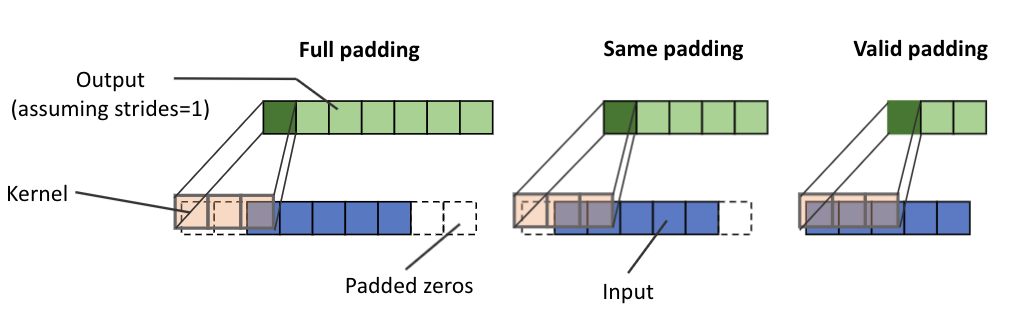

In [4]:
Image(filename='../Python-MachineLearning/Attached_images/Chapter14/figures/14_04.png', 
      width=450)

其中，same padding比较常用，这种方式的一个优点是保持了向量的大小(或者在图像任务中，保留了输入图像的高度和宽度).

valid padding相较于same padding的一个比较大的缺陷是：在具有许多层的NN中，张量的size将大幅减小，这可能会损害网络的性能。

full padding会导致输出大于输入大小，通常用于信号处理中，为了更好地最小化边界效应。

In [5]:
import numpy as np

# 原始数组
array = np.array([[1, 2], [3, 4]])

"""
pad_width=((1, 2), (2, 1)) 的解释：
第一维度 (行): (1, 2)
在行的前面填充 1 行零（在顶部）。
在行的后面填充 2 行零（在底部）。
第二维度 (列): (2, 1)
在列的前面填充 2 列零（在左侧）。
在列的后面填充 1 列零（在右侧）。
"""
padded_array = np.pad(array, pad_width=((1, 2), (2, 1)), mode='constant', constant_values=0)

print("填充后的数组：\n", padded_array)

填充后的数组：
 [[0 0 0 0 0]
 [0 0 1 2 0]
 [0 0 3 4 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]


#### 确定卷积输出的大小

卷积的输出大小由移动滤波器的总次数决定. 这里假设输入向量的size为$n$, 卷积核size为$m$, 步长为$s$, 填充padding为$p$. 于是，输出结果$\boldsymbol{y=x*w}$的size为：

$$o=\left\lfloor\frac{n+2p-m}s\right\rfloor+1$$

#### 实现1维卷积

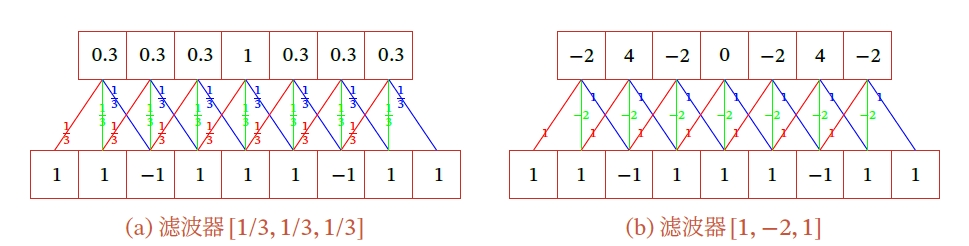

In [6]:
Image('../Python-MachineLearning/Attached_images/Chapter14/figures/Conv1d.png', 
      width=550)

In [7]:
import numpy as np

def conv1d(x, w, p=0, s=1):
    w_rot = np.array(w[::-1])
    x_padded = np.array(x)
    if p > 0:
        zero_pad = np.zeros(shape=p)
        x_padded = np.concatenate([zero_pad, x_padded, zero_pad])
        print(x_padded)
    res = []
    for i in range(0, int((len(x_padded) - len(w_rot))) + 1, s):
        res.append(np.sum(x_padded[i:i+w_rot.shape[0]] * w_rot))
    return np.array(res)

# 调用函数测试.
x = [1, 3, 2, 4, 5, 6, 1, 3]
w = [1, 0, 3, 1, 2]

print('Conv1d Implementation:', conv1d(x, w, p=2, s=1))
print('Numpy Results:', np.convolve(x, w, mode='same'))

[0. 0. 1. 3. 2. 4. 5. 6. 1. 3. 0. 0.]
Conv1d Implementation: [ 5. 14. 16. 26. 24. 34. 19. 22.]
Numpy Results: [ 5 14 16 26 24 34 19 22]


#### 实现二维卷积

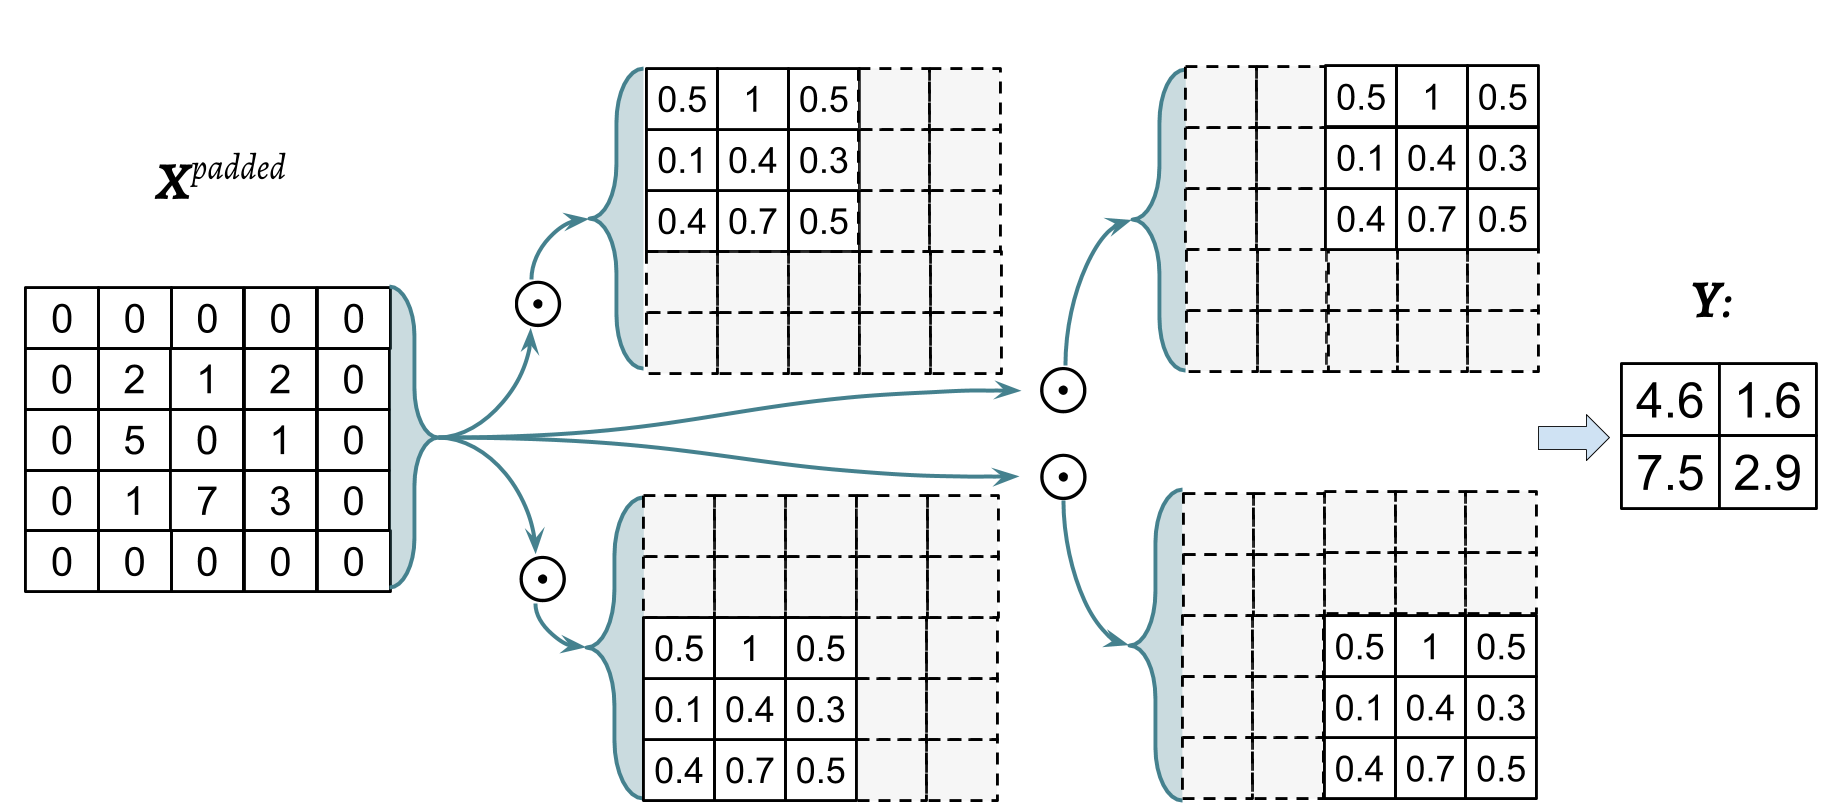

In [8]:
Image(filename='../Python-MachineLearning/Attached_images/Chapter14/figures/14_07.png', 
      width=450)

In [13]:
import numpy as np
import scipy.signal

def conv2d(X, W, p=(0, 0), s=(1, 1)):
    W_rot = np.array(W)[::-1, ::-1]
    X_orig = np.array(X)
    n1 = X_orig.shape[0] + 2*p[0]
    n2 = X_orig.shape[1] + 2*p[1]
    X_padded = np.zeros(shape=(n1, n2))
    X_padded[p[0]:p[0]+X_orig.shape[0], 
             p[1]:p[1]+X_orig.shape[1]] = X_orig
    print("X_padded:\n", X_padded)
    
    res = []
    for i in range(0, int((X_padded.shape[0] - W_rot.shape[0])/s[0])+1, s[0]):
        res.append([])
        for j in range(0, int((X_padded.shape[1] - W_rot.shape[1])/s[1])+1, s[1]):
            X_sub = X_padded[i:i+W_rot.shape[0], j:j+W_rot.shape[1]]
            res[-1].append(np.sum(X_sub * W_rot))
    return (np.array(res))

X = [[1, 3, 2, 4], 
     [5, 6, 1, 3], 
     [1, 2, 0, 2], 
     [3, 4, 3, 2]]
W = [[1, 0, 3], 
     [1, 2, 1], 
     [0, 1, 1]]

print('Conv2d Implementation:\n',
    conv2d(X, W, p=(1, 1), s=(1, 1)))

print('Scipy Results:\n', scipy.signal.convolve2d(X, W, mode='same'))

X_padded:
 [[0. 0. 0. 0. 0. 0.]
 [0. 1. 3. 2. 4. 0.]
 [0. 5. 6. 1. 3. 0.]
 [0. 1. 2. 0. 2. 0.]
 [0. 3. 4. 3. 2. 0.]
 [0. 0. 0. 0. 0. 0.]]
Conv2d Implementation:
 [[11. 25. 32. 13.]
 [19. 25. 24. 13.]
 [13. 28. 25. 17.]
 [11. 17. 14.  9.]]
Scipy Results:
 [[11 25 32 13]
 [19 25 24 13]
 [13 28 25 17]
 [11 17 14  9]]


#### 子采样层

在CNN中，子采样层通常应用于两种形式的池化操作：最大池化和平均池化(max-pooling and mean-pooling). 池化层通常由于$P_{n1\times n2}$表示，其中下表决定了执行最大或均值池化运算的邻域的大小. 示例如下：

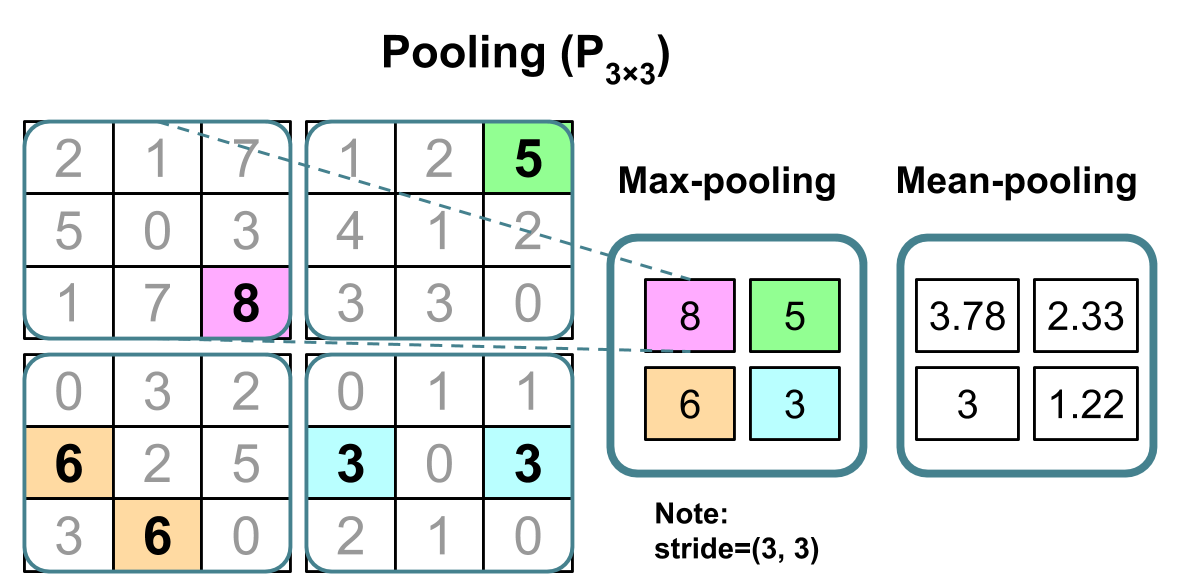

In [14]:
Image(filename='../Python-MachineLearning/Attached_images/Chapter14/figures/14_08.png', 
      width=450)

##### 池化操作的好处

*  **池化操作引入了局部不变性**，这意味着局部邻域中的小变化不会改变最大池化的结果，`有助于生成对输入数据中的噪声更具鲁棒性的特征`。  示例如下：

对矩阵$X_1, X_2$:

$$\begin{aligned}&\boldsymbol{X}_{1}=\begin{bmatrix}10&255&125&0&170&100\\70&255&105&25&25&70\\255&0&150&0&10&10\\0&255&10&10&150&20\\70&15&200&100&95&0\\35&25&100&20&0&60\end{bmatrix}\\\\&\boldsymbol{X}_{2}=\begin{bmatrix}100&100&100&50&100&50\\95&255&100&125&125&170\\80&40&10&10&125&150\\255&30&150&20&120&125\\30&30&150&100&70&70\\70&30&100&200&70&95\end{bmatrix}\end{aligned}$$

最大池化对应结果均为：
$$\xrightarrow{\max\text{pooling }P_{2\times2}}\begin{bmatrix}255&125&170\\255&150&150\\70&200&95\end{bmatrix}$$

* **池化操作减少了特征大小**，从而提高了计算效率。此外，减少特征数量也可以降低过拟合程度.

#### 实现CNN

In [16]:
# 读取彩色图像.
import torch
from torchvision.io import read_image

img = read_image('../Python-MachineLearning/Attached_images/Chapter14/R.jpg')

print('Image shape:', img.shape)            # [channels, image_height, image_width]
print('Number of channels:', img.shape[0])
print('Image data type:', img.dtype)
print('Matrix of the image:', img)

Image shape: torch.Size([3, 3024, 4032])
Number of channels: 3
Image data type: torch.uint8
Matrix of the image: tensor([[[  0,   0,   1,  ..., 167, 167, 167],
         [  0,   0,   1,  ..., 167, 167, 167],
         [  0,   0,   1,  ..., 167, 167, 167],
         ...,
         [ 86,  89,  89,  ..., 140, 140, 140],
         [ 93,  96,  94,  ..., 155, 157, 160],
         [ 87,  90,  89,  ..., 162, 165, 169]],

        [[171, 171, 172,  ..., 217, 217, 217],
         [171, 171, 172,  ..., 217, 217, 217],
         [171, 171, 172,  ..., 217, 217, 217],
         ...,
         [ 57,  60,  60,  ..., 106, 106, 106],
         [ 61,  64,  62,  ..., 121, 123, 126],
         [ 53,  56,  55,  ..., 128, 131, 135]],

        [[225, 225, 226,  ..., 242, 242, 242],
         [225, 225, 226,  ..., 242, 242, 242],
         [225, 225, 226,  ..., 242, 242, 242],
         ...,
         [ 43,  46,  46,  ...,  81,  81,  81],
         [ 48,  51,  49,  ...,  94,  96,  99],
         [ 41,  44,  43,  ..., 101, 103, 1

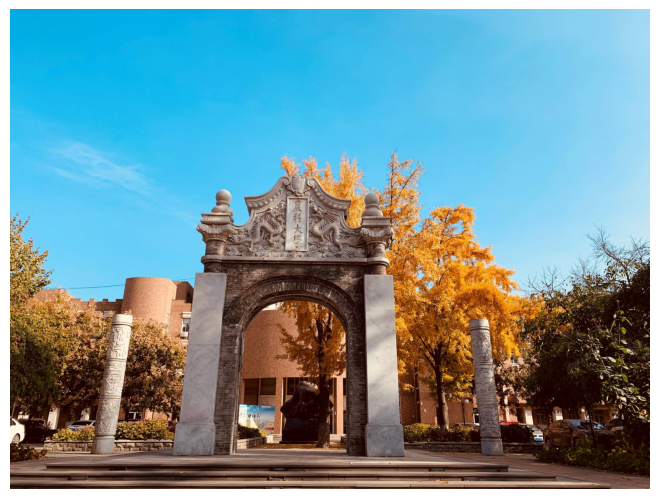

In [18]:
# 显示该示例图像.
import matplotlib.pyplot as plt

plt.imshow(img.permute(1, 2, 0))
plt.axis('off')
plt.show()